This study benchmarks JABIRU API's effective dose rate calculations against the CARI-7 code of the United States Federal Aviation Administration. 

The CSV datafile 'Flight_QF64.DAT' contains a list of Effective Dose Rates calculated by CARI-7 for waypoints of latitude, longitude, and altitude for Flight QF64 from Johannesburg to Sydney on the 28th of July 2018. 

The script overlays the waypoints on a map (see Figure 1), then plots the effective dose rates at these waypoints as calculated by the two codes (see Figure 2). 

Documentation and source code for the CARI-7 code can be found [here](https://www.faa.gov/data_research/research/med_humanfacs/aeromedical/radiobiology/CARI7/)

In [14]:
import codecs
import json
%matplotlib notebook
%matplotlib notebook
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np
import urllib.request
import yaml 

In [15]:
# firstly read the waypoint dataset from the csv file
cari_results = np.loadtxt("./Flight_QF64.DAT", \
    dtype={\
        'names': ('lat', 'long', 'depth', 'step', 'dose rate', 'total dose'), \
        'formats': ('f4', 'f4', 'f4', 'i4', 'f4', 'f4')
    })

In [16]:
# extract longitudes and latitudes 
longitudes = cari_results['long']
latitudes = cari_results['lat']
# CARI-7 considers longitudes as eastings only. We need to convert to eastings and westings
indices = longitudes > 180 
longitudes[indices] = longitudes[indices] - 360 

<IPython.core.display.Javascript object>


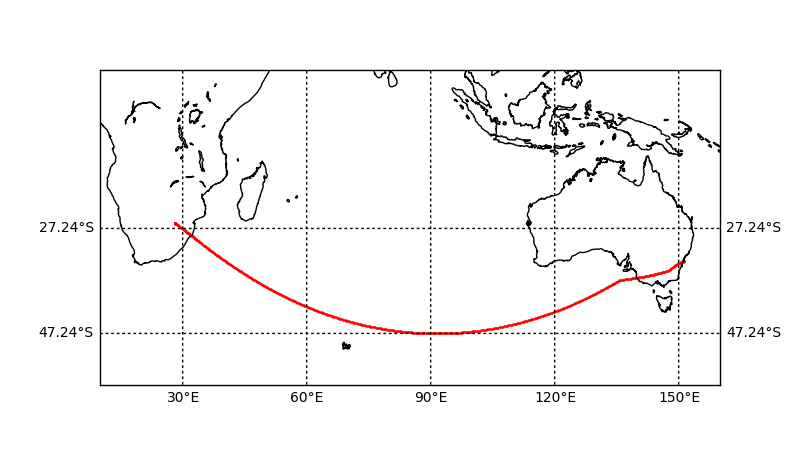

In [17]:
# initialise the map of the world
fig_map = plt.figure(figsize=(8,4.5))
ax_map = fig_map.add_subplot(111)
m = Basemap(llcrnrlon=10., llcrnrlat=-55., urcrnrlon=160., urcrnrlat=10., resolution='l', projection='merc');
m.drawmapboundary(fill_color='#ffffff');
m.drawcoastlines();
#m.fillcontinents();

**Figure 1**: Waypoints for Flight QF64 from Johannesburg to Sydney on 28th of July 2018

In [18]:
# draw waypoints on the map
long, lat = m(longitudes,latitudes)
m.scatter(long, lat, 2, marker='.',color='r', linestyle="-")
# draw parallels and meridians
m.drawparallels(np.arange(np.min(latitudes),np.max(latitudes),20),labels=[1,1,0,1])
m.drawmeridians(np.arange(-180,180,30),labels=[1,1,0,1])
plt.show;
# save a jpg to use as a thumbnail
plt.savefig("benchmark_cari7_map.jpg")


/usr/lib/python3/dist-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/usr/lib/python3/dist-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


<IPython.core.display.Javascript object>


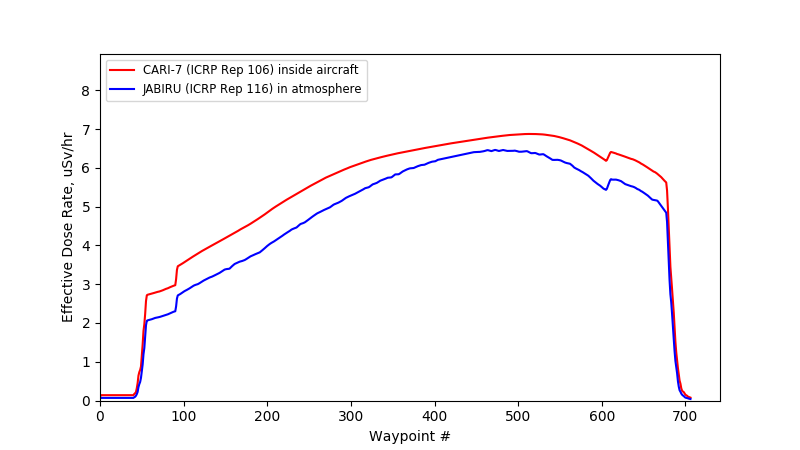

In [19]:
# initialise the figure for plotting Effective Dose Rates vs waypoint number
fig_dose = plt.figure(figsize=(8,4.5))
ax_dose = fig_dose.add_subplot(111)
ax_dose.set_xlabel("Waypoint #")
ax_dose.set_ylabel("Effective Dose Rate, uSv/hr"); 

**Figure 2**: Effective Dose Rate for waypoints along the path of Flight QF64 from Johannesburg to Sydney on 28th of July 2018, as calculated by CARI-7 and the JABIRU API.

## Discussion

The increase in Effective Dose Rate mid-flight is due to two factors: 1. The route takes the flight as far south as -47.24 degrees latitude. The intensity of cosmic rays is generally higher towards the poles due to effects of the Earth's magnetic field; there is a concomitant increase in the Effective Dose rate. 2. The altitude is greater mid-flight.

The Effective Dose Rate calculated by the JABIRU API if systematically lower (approx. 20%) than that predicted by CARI-7. Possible reasons include: 1. CARI-7 doses are calculated using an anthropomorphic phantom inside an aircraft, whereas JABIRU assumes values in atmosphere; and 2. CARI-7 uses dose conversion coefficients from ICRP Report 106 whereas JABIRU uses those in ICRP Report 116. The origin of these discrepancies is under investigation and this analysis will be updated as the API evolves.

In [20]:
reader = codecs.getreader("utf-8")
plt.show()

In [21]:
# construct the target API URL
hostname = "https://api.amentum.space"

api_url = hostname + "/api/calculate_dose_rate?"
# append other parameters to the query string to set the date and particle type  
api_url += "year=2018&"
api_url += "month=7&"
api_url += "day=28&"
api_url += "particle=total&"

In [22]:
# initialise lists to store dose rates 
jabiru_dose_rates = []
cari_dose_rates = []

for step in cari_results:
    # append parameters specific to each waypoint to the target API URL
    this_url = api_url
    cari_dose_rates.append(step['dose rate'])
    this_url += "latitude="+np.str(step['lat'])+"&"
    longitude = step['long']
    if longitude > 180 : longitude -= 360 
    this_url += "longitude="+np.str(longitude)+"&"
    this_url += "atmospheric_depth="+np.str(step['depth'])
    
    # hit the Jabiru API and fetch the effective dose rate
    try:
        response = urllib.request.urlopen(this_url)
    except urllib.error.URLError as e: 
        ResponseData = e.reason
        print("ERROR: ", ResponseData)
    
    json_payload = json.load(reader(response))
    
    dose_rate = json_payload["dose rate"]["value"] # uSv/hr
    
    jabiru_dose_rates.append(dose_rate)

In [23]:
ax_dose.plot(cari_dose_rates  # uSv/hr
    , linestyle = "-"
    , marker = "None"
    , color = "r"
    , label = "CARI-7 (ICRP Rep 106) inside aircraft");

In [24]:
ax_dose.plot(jabiru_dose_rates  # uSv/hr
    , linestyle = "-"
    , marker = "None"
    , color = "b"
    , label = "JABIRU (ICRP Rep 116) in atmosphere");

In [25]:
ax_dose.legend(loc="upper left", fontsize = 'small', numpoints = 1);

In [26]:
ax_dose.set_ylim(ymin=0, ymax=1.3*np.max(cari_dose_rates));
ax_dose.set_xlim(xmin=0);